# Perceptron

* Give biological introduction, provide two images - one biological, one artificial
* Explain how the algorithm works mathematically
* Maybe give an animation of how the discriminative line moves
* They can be trained to implement an AND gate

1. Initialize the weights
2. For each training sample $\mathbf{x}^{(i)}$
    3. Compute $\hat{y}^{(i)} = \phi (\mathbf{w}^T \mathbf{x}^{(i)})$
    4. Compute $\mathbf{w} := \mathbf{w} + \eta(y^{(i)} - \hat{y}^{(i)}) \mathbf{x}^{(i)}$

* In the case that $y^{(i)} = \hat{y}^{(i)}$ the weights remain unchanged
* In the case that $y^{(i)} \neq \hat{y}^{(i)}$ the weights are moved in the direction of $\mathbf{x}^{(i)}$. This is because if $\hat{y}^{(i)}$ is negative and it should be positive, i.e. $z$ is too small, we  $2\eta \mathbf{x}^{(i)}$, i.e. the vectors w and x are too orthogonal, so we should move in the direciton of the other (but we can't move x). Adding multiple of the vector ensures that. The other case is analogous, but instead we subtract it  (move it away).
* The classes must be linearly separable.

In [158]:
import numpy as np

class Perceptron:
    
    def __init__(self, num_iters=100, learning_rate=1, epsilon=0.01, init_mean=0.0, init_std=0.01):
        self.num_iters = num_iters
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.init_mean = 0.0
        self.init_std = 0.01
        self.random_state = 0
    
    def fit(self, X, Y):
        self.loss_history_ = []
        
        self._init_weights(X)
        
        for _ in range(self.num_iters):
            num_errors = 0
            for x, y in zip(X, Y):
                y_hat = self._predict(x)
                num_errors += 1 if y_hat != y else 0
                self._update_weights(y_hat, x, y)
            loss = num_errors / len(X)
            self.loss_history_.append(loss)
            if loss < self.epsilon:
                break
                
    def _predict(self, x):
        return self._step_function(np.dot(x, self.w_[1:]))
    
    def _step_function(self, z):
        return 1 if z >= 0 else -1
    
    def _init_weights(self, X):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1]+1)
        
    def _update_weights(self, y_hat, x, y):
        update = self.learning_rate * (y-y_hat)
        self.w_[1:] += update*x
        self.w_[0] += update 


In [147]:
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.sort_values(by=4)
print('Unique classes: {}'.format(', '.join(df[4].unique())))

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
27,5.2,3.5,1.5,0.2,Iris-setosa
28,5.2,3.4,1.4,0.2,Iris-setosa
29,4.7,3.2,1.6,0.2,Iris-setosa
30,4.8,3.1,1.6,0.2,Iris-setosa
31,5.4,3.4,1.5,0.4,Iris-setosa
32,5.2,4.1,1.5,0.1,Iris-setosa
33,5.5,4.2,1.4,0.2,Iris-setosa
34,4.9,3.1,1.5,0.1,Iris-setosa
35,5.0,3.2,1.2,0.2,Iris-setosa


Unique classes: Iris-setosa, Iris-versicolor, Iris-virginica


In [112]:
train_size = 100
test_size = 50
X_train, y_train = df.iloc[:train_size, :-1].values, df.iloc[:train_size, 4].values
y_train = np.where(y_train == 'Iris-setosa', -1, 1)

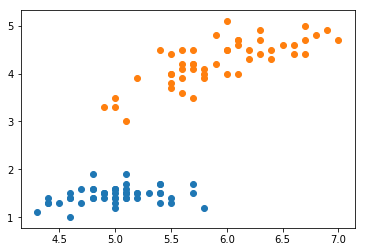

In [113]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:50, 0], X_train[:50, 2])
plt.scatter(X_train[50:, 0], X_train[50:, 2])
plt.show()

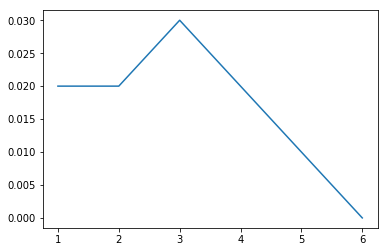

In [159]:
perc = Perceptron(num_iters=10, learning_rate=0.1)
perc.fit(X_train[:, (0,2)], y_train)
plt.plot(range(1, len(perc.loss_history_)+1), perc.loss_history_)
plt.show()

In [ ]:
X